# CRISP DM


## Problem Understanding:
A central step in the ORCA pipeline is the automated mapping of natural language threat
descriptions to structured attack patterns from the Common Attack Pattern Enumeration
and Classification (CAPEC) framework. This process—referred to as Threat-to-CAPEC
Mapping—aims to translate unstructured textual threat inputs into standardized, machine-
readable representations that describe how an attacker might exploit a given vulnerability.
This mapping is critical for enabling further steps in the security analysis process, such
as correlating threats with known vulnerabilities (CWEs, CVEs), assessing risk using
scoring systems like CVSS, and informing mitigation strategies. However, the task poses
several inherent challenges:
Ambiguity: Threat descriptions are often informal, incomplete, or context-dependent.
Terminology mismatch: Natural language inputs may not directly align with the technical
vocabulary used in CAPEC definitions.
Granularity: A single threat may correspond to multiple CAPECs at varying levels of
abstraction, requiring semantic reasoning to determine relevance.
Solving this problem involves designing a system capable of understanding the semantics
of threat descriptions and reliably identifying the most appropriate CAPEC entries. This
step must balance accuracy, scalability, and interpretability to support reliable, automated
security assessments within the broader ORCA framework.

## Data Understanding

In [5]:
# imports
import pandas as pd
import json
import re
import ollama
from IPython.display import HTML, display
from git import Repo, InvalidGitRepositoryError
import os
import shutil

from stix2 import FileSystemSource
from stix2 import Filter

from sentence_transformers import SentenceTransformer, util
import torch
import chromadb
import uuid

c:\Users\domep\Development\Masterarbeit\MasterThesis_LLM_optimization_ORCA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setting display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Import threat data from json file

In [3]:
# Load threat data from JSON file into a DataFrame
df_threats = pd.read_json('threat_data/all_threats.json')
df_threats.head(5)

,Threat ID,Threat title,Threat Description,Threat type,Impact type,Threat agent,Vulnerability,Threatened Asset,Affected Components
0,T-O-RAN-01,An attacker exploits insecure designs or lack of adaption in O-RAN components,"Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.\nIn addition, O-RAN components could be software providing network functions, so they are likely to be vulnerable to software flaws: it could be possible to bypass firewall restrictions or to take advantage of a buffer overflow to execute arbitrary commands, etc.",None,None,All,"[Outdated component from the lack of update or patch management, Poorly design architecture, Missing appropriate security hardening, Unnecessary or insecure function/protocol/component]",All,All
1,T-O-RAN-02,An attacker exploits misconfigured or poorly configured O-RAN components,"Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the configuration of the hardware-software O-RAN system. \nO-RAN components might be vulnerable if: \n• Errors from the lack of configuration change management,\n• Misconfigured or poorly configured O-RAN components,\n• Improperly configured permissions,\n• Unnecessary features are enabled (e.g. unnecessary ports, services, accounts, or privileges),\n• Default accounts and their passwords still enabled and unchanged,\n• Security features are disabled or not configured securely.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.",None,None,All,"[Errors from the lack of configuration change management, Misconfigured or poorly configured O-RAN components, Improperly configured permissions, Unnecessary features are enabled (e.g. unnecessary ports, services, accounts, or privileges), Default accounts and their passwords still enabled and unchanged, Security features are disabled or not configured securely]",All,All
2,T-O-RAN-03,Attacks from the internet to penetrate O-RAN network boundary,"Web servers serving O-RAN functional and management services should provide adequate protection. \nAn attacker that have access to the uncontrolled O-RAN network could:\n• Bypass the information flow control policy implemented by the firewall,\n• And/or attack O-RAN components in the trusted networks by taking advantage of particularities and errors in the design and implementation of the network protocols (IP, TCP, UDP, application protocols),\n• Use of incorrect or exceeded TCP sequence numbers,\n• Perform brute force attacks on FTP passwords,\n• Use of improper HTTP user sessions,\n• Etc.\nThe effects of such attacks may include:\n• An intrusion, 

In [4]:
# Display DataFrame information
df_threats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Threat ID            182 non-null    object
 1   Threat title         182 non-null    object
 2   Threat Description   182 non-null    object
 3   Threat type          82 non-null     object
 4   Impact type          82 non-null     object
 5   Threat agent         182 non-null    object
 6   Vulnerability        182 non-null    object
 7   Threatened Asset     182 non-null    object
 8   Affected Components  182 non-null    object
dtypes: object(9)
memory usage: 12.9+ KB


There a 182 threats in 9 columns, each threat has a unique ID, a title, a description, a threat type, an impact type, a threat agent, one or more vulnerabilities (safed in a list), a threatened asset and a affected component

In [5]:
df_threats.describe()

,Threat ID,Threat title,Threat Description,Threat type,Impact type,Threat agent,Vulnerability,Threatened Asset,Affected Components
count,182,182,182,82,82,182,182,182,182
unique,182,181,182,16,17,2,116,58,55
top,T-O-RAN-01,External attacker exploits authentication weakness on SMO,"Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.\nIn addition, O-RAN components could be software providing network functions, so they are likely to be vulnerable to software flaws: it could be possible to bypass firewall restrictions or to take advantage of a buffer overflow to execute arbitrary commands, etc.",Spoofing,Authenticity,All,[weak mutual authentication],"ASSET-D-12, ASSET-D-13, ASSET-D-14, ASSET-D-15, ASSET-D-16, ASSET-D-17, ASSET-D-18, ASSET-D-19, ASSET-D-20, ASSET-D-29, ASSET-D-31, ASSET-D-32",All
freq,1,2,1,28,26,178,12,24,19


In [98]:
from IPython.display import HTML, Markdown, display

display(HTML('''
<style>
/* White background for output area */
.output_area {
    background: white !important;
    color: black !important;
}

/* Optional: White background for DataFrame cells */
.dataframe {
    background-color: white !important;
    color: black !important;
}
</style>
'''))



In [7]:
df_threats.isnull().sum()

Threat ID                0
Threat title             0
Threat Description       0
Threat type            100
Impact type            100
Threat agent             0
Vulnerability            0
Threatened Asset         0
Affected Components      0
dtype: int64

In [8]:
df_threats.columns

Index(['Threat ID', 'Threat title', 'Threat Description', 'Threat type',
       'Impact type', 'Threat agent', 'Vulnerability', 'Threatened Asset',
       'Affected Components'],
      dtype='object')

In [9]:
df_threats.groupby('Threat type').size().reset_index(name='count').sort_values(by='count', ascending=False).reset_index(drop=True)

,Threat type,count
0,Spoofing,28
1,Denial of Service,11
2,Elevation of Privilege,10
3,Information Disclosure,9
4,Tampering,8
5,Information disclosure,4
6,Tampering; Denial of Service,2
7,"Elevation of Privilege, Information Disclosure",2
8,Elevation of Privilege; Denial of Service,1
9,"Denial of Service, Escalation of Privilege",1


In [10]:
(df_threats['Threat type'].isnull() == df_threats['Impact type'].isnull()).all()


np.True_

In [11]:
df_threats['Threat type'].value_counts(dropna=False)

Threat type
None                                                          52
NaN                                                           48
Spoofing                                                      28
Denial of Service                                             11
Elevation of Privilege                                        10
Information Disclosure                                         9
Tampering                                                      8
Information disclosure                                         4
Elevation of Privilege, Information Disclosure                 2
Tampering; Denial of Service                                   2
Information disclosure, Tampering                              1
Tampering, Information Disclosure, Escalation of Privilege     1
Denial of Service, Escalation of Privilege                     1
Denial of Service; Tampering                                   1
Elevation of Privilege; Denial of Service                      1
Tampering; El

In [12]:
df_threats['Impact type'].value_counts(dropna=False)

Impact type
None                                         52
NaN                                          48
Authenticity                                 26
Confidentiality                              14
Availability                                 12
Authorization                                 9
Integrity                                     7
Authentication                                2
Integrity; Availability                       2
Authorization. Confidentiality                1
Integrity, Confidentiality, Authorization     1
Availability; Integrity                       1
Confidentiality, Integrity                    1
Authorization; Availability                   1
Integrity; Authorization; Availability        1
Integrity, Availability                       1
Availability, Confidentiality                 1
Confidentiality, Availability                 1
Authorization, Availability                   1
Name: count, dtype: int64

In [13]:
df_threats['Vulnerability'].value_counts(dropna=False)

Vulnerability
[weak mutual authentication]                                                                                                                                                                                                                                                     12
[Weak authentication can be exploited by a tenant to move laterally across the deployment.]                                                                                                                                                                                       9
[Lack of integrity verification]                                                                                                                                                                                                                                                  5
[Lack of overload protection and rate-limiting]                                                                                                               

### Distribution Analysis


In [14]:
# some threat types as well as impact types are seperated by a comma, while others are seperated by a semicolon or a point
# Replace all semicolons with commas
df_threats['Threat type'] = df_threats['Threat type'].str.replace(';', ',', regex=False)
df_threats['Threat type'] = df_threats['Threat type'].str.replace('.', ',', regex=False)
df_threats['Impact type'] = df_threats['Impact type'].str.replace(';', ',', regex=False)
df_threats['Impact type'] = df_threats['Impact type'].str.replace('.', ',', regex=False)
# in the Threatened asssets column, some values have a underscore instead of a dash
df_threats['Threatened Asset'] = df_threats['Threatened Asset'].str.replace('_', '-', regex=False)

In [15]:
# removing leading and trailing whitespace from the 'Threat type','Impact type','Threatened asset' and 'Affected components' columns
df_threats['Threat type'] = df_threats['Threat type'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)
df_threats['Impact type'] = df_threats['Impact type'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)
df_threats['Threatened Asset'] = df_threats['Threatened Asset'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)
df_threats['Affected Components'] = df_threats['Affected Components'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)
# the vulnerability column contains a list with only one string element
# this string contains multpile vulnerabilities separated by commas
# we convert the list to this one string element and then split the string by commas
df_threats['Vulnerability'] = df_threats['Vulnerability'].apply(lambda x: x[0] if isinstance(x, list) else x)
df_threats['Vulnerability'] = df_threats['Vulnerability'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)

In [16]:
# the 'Threatened Asset' column contains values like 'All' or 'ASSET-D-33 to ASSET-D-38', we solve this by manually turning this into the correct list


# Example: start from your DataFrame
# df_threats = pd.read_json(...)  # or however you're loading it

# Step 1: Drop NaNs
asset_entries = df_threats['Threatened Asset'].dropna()

# Step 2: Function to expand ranges like 'ASSET-D-33 to ASSET-D-38'
def expand_range(entry):
    match = re.match(r"(ASSET-[A-Z]-)(\d+)\s+to\s+ASSET-[A-Z]-(\d+)", entry.strip())
    if match:
        prefix, start, end = match.groups()
        return [f"{prefix}{i}" for i in range(int(start), int(end) + 1)]
    return [entry.strip()]

# Step 3: Build the set of unique assets
all_assets = set()

for entry in asset_entries:
    # If entry is a list, turn it into a string
    if isinstance(entry, list):
        entry = ', '.join(entry)
    
    # Ensure it's a string before splitting
    if isinstance(entry, str):
        parts = [p.strip() for p in entry.split(',')]
        for part in parts:
            if part.lower() == 'all':
                continue  # or expand to full known asset list if desired
            elif 'to' in part:
                expanded = expand_range(part)
                all_assets.update(expanded)
            else:
                all_assets.add(part.strip())

# Step 4: Show all unique asset names sorted
all_assets = sorted(all_assets)
print(all_assets)




['ASSET D-11', 'ASSET D-20', 'ASSET D-21', 'ASSET-C-02', 'ASSET-C-03', 'ASSET-C-07', 'ASSET-C-08', 'ASSET-C-09', 'ASSET-C-1', 'ASSET-C-10', 'ASSET-C-11', 'ASSET-C-12', 'ASSET-C-14', 'ASSET-C-16', 'ASSET-C-17', 'ASSET-C-18', 'ASSET-C-19', 'ASSET-C-2', 'ASSET-C-20', 'ASSET-C-21', 'ASSET-C-22', 'ASSET-C-23', 'ASSET-C-24', 'ASSET-C-25', 'ASSET-C-26', 'ASSET-C-27', 'ASSET-C-28', 'ASSET-C-3', 'ASSET-C-31', 'ASSET-C-32', 'ASSET-C-33', 'ASSET-C-34', 'ASSET-C-35', 'ASSET-C-36', 'ASSET-C-37', 'ASSET-C-38', 'ASSET-C-39', 'ASSET-C-4', 'ASSET-C-40', 'ASSET-C-42', 'ASSET-C-5', 'ASSET-C-6', 'ASSET-C-7', 'ASSET-C-8', 'ASSET-C-9', 'ASSET-D-01', 'ASSET-D-02', 'ASSET-D-03', 'ASSET-D-04', 'ASSET-D-05', 'ASSET-D-06', 'ASSET-D-07', 'ASSET-D-08', 'ASSET-D-09', 'ASSET-D-1', 'ASSET-D-10', 'ASSET-D-11', 'ASSET-D-12', 'ASSET-D-13', 'ASSET-D-14', 'ASSET-D-15', 'ASSET-D-16', 'ASSET-D-17', 'ASSET-D-18', 'ASSET-D-19', 'ASSET-D-2', 'ASSET-D-20', 'ASSET-D-21', 'ASSET-D-22', 'ASSET-D-23', 'ASSET-D-24', 'ASSET-D-25', 'A

In [17]:
def normalize_assets(value):
    # Convert list to string if needed
    if isinstance(value, list):
        value = ', '.join(value)
    
    if isinstance(value, str):
        value = value.strip()
        if value.lower() == 'all':
            return all_assets
        elif 'to' in value:
            return expand_range(value)
        else:
            # handle comma-separated list like 'ASSET-D-15, ASSET-C-17'
            return [v.strip() for v in value.split(',')]
    
    return value  # leave as-is if unexpected

df_threats['Threatened Asset'] = df_threats['Threatened Asset'].apply(normalize_assets)



In [18]:
df_threats['Threatened Asset'].head(20)

0     [ASSET D-11, ASSET D-20, ASSET D-21, ASSET-C-02, ASSET-C-03, ASSET-C-07, ASSET-C-08, ASSET-C-09, ASSET-C-1, ASSET-C-10, ASSET-C-11, ASSET-C-12, ASSET-C-14, ASSET-C-16, ASSET-C-17, ASSET-C-18, ASSET-C-19, ASSET-C-2, ASSET-C-20, ASSET-C-21, ASSET-C-22, ASSET-C-23, ASSET-C-24, ASSET-C-25, ASSET-C-26, ASSET-C-27, ASSET-C-28, ASSET-C-3, ASSET-C-31, ASSET-C-32, ASSET-C-33, ASSET-C-34, ASSET-C-35, ASSET-C-36, ASSET-C-37, ASSET-C-38, ASSET-C-39, ASSET-C-4, ASSET-C-40, ASSET-C-42, ASSET-C-5, ASSET-C-6, ASSET-C-7, ASSET-C-8, ASSET-C-9, ASSET-D-01, ASSET-D-02, ASSET-D-03, ASSET-D-04, ASSET-D-05, ASSET-D-06, ASSET-D-07, ASSET-D-08, ASSET-D-09, ASSET-D-1, ASSET-D-10, ASSET-D-11, ASSET-D-12, ASSET-D-13, ASSET-D-14, ASSET-D-15, ASSET-D-16, ASSET-D-17, ASSET-D-18, ASSET-D-19, ASSET-D-2, ASSET-D-20, ASSET-D-21, ASSET-D-22, ASSET-D-23, ASSET-D-24, ASSET-D-25, ASSET-D-26, ASSET-D-27, ASSET-D-28, ASSET-D-29, ASSET-D-3, ASSET-D-30, ASSET-D-31, ASSET-D-32, ASSET-D-33, ASSET-D-34, ASSET-D-35, ASSET-D-3

In [19]:
df_threats['Threat type'].explode().value_counts()
# The most common threat type is Spoofing, which occurs 28 times

Threat type
Spoofing                   28
Denial of Service          19
Elevation of Privilege     14
Information Disclosure     14
Tampering                  14
Information disclosure      5
Escalation of Privilege     2
Name: count, dtype: int64

In [20]:
df_threats['Vulnerability'].explode().str.lower().value_counts()
# The most common vulnerability is 'lack of authentication', which occurs 17 times,
# followed by 'lack of authentication' with 12 occurences.

Vulnerability
lack of authentication                                                                       17
weak mutual authentication                                                                   12
weak authentication can be exploited by a tenant to move laterally across the deployment.     9
missing or improperly configured authorization                                                6
lack of integrity verification                                                                6
                                                                                             ..
pnfs                                                                                          1
etc.                                                                                          1
operation areas                                                                               1
physical access to the open fronthaul cable network                                           1
use of pretrained public m

In [21]:
# Step 3: Explode the list so each asset appears in its own row
asset_flat = df_threats.explode('Threatened Asset')

# Step 4: Count how often each asset appears
asset_counts = asset_flat['Threatened Asset'].value_counts()
asset_counts.head(50)

Threatened Asset
ASSET-D-15    43
ASSET-C-17    41
ASSET-D-29    40
ASSET-D-18    38
ASSET-D-14    37
ASSET-C-31    35
ASSET-D-17    35
ASSET-D-16    35
ASSET-D-12    34
ASSET-D-13    34
ASSET-D-19    34
ASSET-D-20    34
ASSET-D-32    34
ASSET-D-31    33
ASSET-C-11    33
ASSET-C-18    22
ASSET-C-10    21
ASSET-C-08    19
ASSET-C-35    18
ASSET-D-01    18
ASSET-C-34    17
ASSET-C-26    17
ASSET-C-19    16
ASSET-C-16    16
ASSET-C-20    16
ASSET-C-21    16
ASSET-C-23    16
ASSET-C-09    16
ASSET-D-04    15
ASSET-D-26    15
ASSET-D-25    15
ASSET-C-37    15
ASSET-D-37    15
ASSET-D-34    15
ASSET-D-33    15
ASSET-D-36    15
ASSET-D-35    15
ASSET-D-38    15
ASSET-C-25    14
ASSET-C-36    14
ASSET-D-21    14
ASSET-D-02    14
ASSET-D-05    14
ASSET-D-27    13
ASSET-D-28    13
ASSET-D-06    13
ASSET-D-10    13
ASSET-D-22    13
ASSET-C-02    12
ASSET-D-43    12
Name: count, dtype: int64

In [22]:
df_threats['Impact type'].explode().value_counts()

Impact type
Authenticity       26
Availability       21
Confidentiality    19
Authorization      14
Integrity          14
Authentication      2
Name: count, dtype: int64

In [23]:
df_threats['Threat type'].explode().value_counts()

Threat type
Spoofing                   28
Denial of Service          19
Elevation of Privilege     14
Information Disclosure     14
Tampering                  14
Information disclosure      5
Escalation of Privilege     2
Name: count, dtype: int64

In [24]:
print(set(df_threats['Threat agent']))

{'All', 'All except Script kiddies'}


In [25]:
df_threats['Threat agent'].value_counts()

Threat agent
All                          178
All except Script kiddies      4
Name: count, dtype: int64

In [26]:
df_threats['Affected Components'].explode().value_counts() 

Affected Components
O-Cloud                  30
Non-RT RIC               29
Shared O-RU              26
Apps/VNFs/CNFs           22
All                      19
O-DU                     17
O-RU                     16
rApps                    16
Near-RT RIC              16
SMO                      14
xApps                    12
O-DU Tenant              10
SMO Framework            10
O-DU Host                 9
O-CU                      8
O2 interface              7
External interfaces       7
R1 interface              7
UE                        7
SMO Functions             6
ASSET-C-29                6
ASSET-C-30                6
O-CU Tenant               6
CUS-Plane                 5
Apps/VNFs/CNFs images     5
O-CU Host                 5
ASSET-C-08                3
A1 interface              3
E2 interface              3
M-Plane                   3
SMO Host                  3
SMO Tenant                3
xAPPs                     3
Y1 interface              2
O2                        2


In [27]:
df_threats.columns

Index(['Threat ID', 'Threat title', 'Threat Description', 'Threat type',
       'Impact type', 'Threat agent', 'Vulnerability', 'Threatened Asset',
       'Affected Components'],
      dtype='object')

### Text analysis

In [28]:
length_of_threat_descriptions = df_threats['Threat Description'].str.len()
print(length_of_threat_descriptions.describe())
print("The average character length of the threat descriptions is", length_of_threat_descriptions.mean())
# the average length og the threat descriptions is 528.2 characters

standard_deviation = length_of_threat_descriptions.std()
print("The standard deviation of the character length of the threat descriptions is", standard_deviation)

count     182.000000
mean      528.818681
std       491.740145
min        76.000000
25%       187.250000
50%       319.000000
75%       756.250000
max      2668.000000
Name: Threat Description, dtype: float64
The average character length of the threat descriptions is 528.8186813186813
The standard deviation of the character length of the threat descriptions is 491.74014505307065


In [29]:
length_of_threat_titles = df_threats['Threat title'].str.len()
print(length_of_threat_titles.describe())
print("The average character length of the threat titles is", length_of_threat_titles.mean())
print("The standard deviation of the character length of the threat titles is", length_of_threat_titles.std())

count    182.00000
mean      57.10989
std       27.82580
min       14.00000
25%       34.00000
50%       54.00000
75%       70.00000
max      148.00000
Name: Threat title, dtype: float64
The average character length of the threat titles is 57.10989010989011
The standard deviation of the character length of the threat titles is 27.825800083090165


In [30]:

print(df_threats['Threat Description'].value_counts().head(2))
print(df_threats['Threat title'].value_counts().head(2))

Threat Description
Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches

In [31]:
df_threats[df_threats['Threat title'] == 'External attacker exploits authentication weakness on SMO']


,Threat ID,Threat title,Threat Description,Threat type,Impact type,Threat agent,Vulnerability,Threatened Asset,Affected Components
42,T-SMO-01,External attacker exploits authentication weakness on SMO,"An external attacker can exploit the improper/missing authentication weakness on SMO functions. If the authentication of O-RAN subjects on A1, O1, O2, and External interfaces on SMO is not supported or not properly implemented, those interfaces without proper credentials could be exploited to gain access to the SMO.",[Spoofing],[Authenticity],All,[Missing or improperly configured authentication],"[ASSET-C-11, ASSET-C-17]","[Non-RT RIC, SMO Framework]"
43,T-SMO-02,External attacker exploits authentication weakness on SMO,"An external attacker can exploit the improper/missing authorization weakness on SMO functions. A malicious external entity on A1, O1, O2, and External interfaces without authorization or with an incorrect access token may invoke the SMO functions. The data at rest related to that function will be leaked to the attacker. In addition, an attacker can be able to perform certain actions, e.g. disclose O-RAN sensitive information or alter O-RAN components.","[Elevation of Privilege, Information Disclosure]","[Authorization, Confidentiality]",All,[Missing or improperly configured authorization],"[ASSET-C-11, ASSET-C-17]","[Non-RT RIC, SMO Framework]"


### Data understanding of CAPEC data

In [32]:
from git import Repo, InvalidGitRepositoryError
import os
import shutil

from stix2 import FileSystemSource
from stix2 import Filter

In [33]:
def pull_clone_gitrepo(directory, repo):
    # Check if the data direcory exists
    if not os.path.isdir(directory):
        Repo.clone_from(repo, directory)
    else:
        try:
            # Check if the data directory is actually a repositry then pull the canges
            repo = Repo(directory)
            repo.remotes.origin.pull()
        except InvalidGitRepositoryError:
            # If not then remove the folder
            shutil.rmtree(directory)
            Repo.clone_from(repo, directory)

def prepare_capecs_df():
    pull_clone_gitrepo('./data', 'https://github.com/mitre/cti')
    fs = FileSystemSource('./data/capec/2.1')
    filt = Filter('type', '=', 'attack-pattern')

    attack_patterns = fs.query([filt])

    data_array = []
    for pattern in attack_patterns:
        if not pattern.x_capec_status == "Deprecated":
            info = []
            result = [obj for obj in pattern.external_references if obj['source_name'] == "capec"]
            info.append(result[0].external_id)
            info.append(pattern.name)
            info.append(pattern.description)
            if "x_capec_domains" in pattern:
                info.append(pattern.x_capec_domains)
            else:
                info.append("not given")
            data_array.append(info)

    columns = ['CAPEC ID', 'capec_name', 'capec_description', 'capec_domain']
    df = pd.DataFrame(data_array, columns=columns)

    df['summary'] = ''
    for index, row in df.iterrows():
        if len(row['capec_domain']) > 1:
            domains_string = ". The Domains of this are: "+', '.join(row['capec_domain'])
        else:
            domains_string = ". The Domain of this is: "+row['capec_domain'][0]

        summary = 'A CAPEC with the title '+row['capec_name']+\
                    '. The description of this CAPEC is: '+row['capec_description']+\
                    domains_string
        
        df.at[index, 'summary'] = summary
    return df


In [34]:
#generate the capecs_df
#capecs_df = prepare_capecs_df()
##safe capecs data to pickle
#capecs_df.to_pickle('capec_data/capecs.pk1')

In [39]:
#load capecs data from pickle
capecs_df = pd.read_pickle('capec_data/capecs.pk1')

In [40]:
# Display general information about capecs_df
print("Shape of capecs_df:", capecs_df.shape)
print("\nColumn names:", capecs_df.columns.tolist())
print("\nMissing values per column:\n", capecs_df.isnull().sum())
print("\nData types:\n", capecs_df.dtypes)
print("\nFirst 5 rows:")
display(capecs_df.head())
print("\nSummary statistics for text length in 'capec_description':")
desc_lengths = capecs_df['capec_description'].dropna().str.len()
print(desc_lengths.describe())

Shape of capecs_df: (559, 5)

Column names: ['CAPEC ID', 'capec_name', 'capec_description', 'capec_domain', 'summary']

Missing values per column:
 CAPEC ID             0
capec_name           0
capec_description    0
capec_domain         0
summary              0
dtype: int64

Data types:
 CAPEC ID             object
capec_name           object
capec_description    object
capec_domain         object
summary              object
dtype: object

First 5 rows:


,CAPEC ID,capec_name,capec_description,capec_domain,summary
0,CAPEC-87,Forceful Browsing,An attacker employs forceful browsing (direct ...,[Software],A CAPEC with the title Forceful Browsing. The ...
1,CAPEC-391,Bypassing Physical Locks,An attacker uses techniques and methods to byp...,[Physical Security],A CAPEC with the title Bypassing Physical Lock...
2,CAPEC-4,Using Alternative IP Address Encodings,This attack relies on the adversary using unex...,[Software],A CAPEC with the title Using Alternative IP Ad...
3,CAPEC-185,Malicious Software Download,An attacker uses deceptive methods to cause a ...,[Software],A CAPEC with the title Malicious Software Down...
4,CAPEC-226,Session Credential Falsification through Manip...,An attacker manipulates an existing credential...,[Software],A CAPEC with the title Session Credential Fals...



Summary statistics for text length in 'capec_description':
count     559.000000
mean      474.048301
std       224.179346
min         0.000000
25%       301.500000
50%       427.000000
75%       624.000000
max      1069.000000
Name: capec_description, dtype: float64


In [41]:
# show rows with missing values in 'capec_description'
capecs_df[capecs_df['capec_description'].isnull()]

,CAPEC ID,capec_name,capec_description,capec_domain,summary


In [42]:
capecs_df[capecs_df['capec_domain'] == 'not given']

,CAPEC ID,capec_name,capec_description,capec_domain,summary
81,CAPEC-699,Eavesdropping on a Monitor,An Adversary can eavesdrop on the content of a...,not given,A CAPEC with the title Eavesdropping on a Moni...


In [43]:
capecs_df['capec_domain'].value_counts()

capec_domain
[Software]                                                                     287
[Communications, Software]                                                      67
[Social Engineering]                                                            30
[Software, Hardware]                                                            28
[Physical Security]                                                             15
[Communications]                                                                13
[Software, Physical Security, Hardware]                                          9
[Software, Software, Software]                                                   9
[Supply Chain, Hardware]                                                         9
[Social Engineering, Supply Chain, Software]                                     8
[Supply Chain, Physical Security, Hardware]                                      8
[Supply Chain, Software]                                                  

In [44]:
# value counts for 'capec_domain'
capecs_df['capec_domain'].explode().value_counts(dropna=False)

capec_domain
Software              490
Communications        101
Hardware               91
Social Engineering     66
Supply Chain           52
Physical Security      39
not given               1
Name: count, dtype: int64

In [45]:
duplicates = capecs_df[capecs_df['capec_domain'].apply(lambda x: len(x) != len(set(x)))]['capec_domain']

print(f"Count of rows with duplicates: {len(duplicates)}")
print(duplicates)


Count of rows with duplicates: 30
25                        [Software, Software, Software]
29                                  [Software, Software]
54                                  [Hardware, Hardware]
80                        [Software, Software, Software]
81                                             not given
86     [Social Engineering, Social Engineering, Softw...
91              [Social Engineering, Social Engineering]
99                                  [Software, Software]
119                       [Software, Software, Software]
123                                 [Hardware, Hardware]
156             [Social Engineering, Social Engineering]
165                                 [Software, Software]
177                       [Software, Software, Software]
201             [Social Engineering, Social Engineering]
225                       [Software, Software, Software]
243                       [Software, Hardware, Software]
262             [Social Engineering, Social Engineerin

## Data Preparation

Merging title and description to match the form of the original orca pipeline.

In [42]:
threats_summary_context = {'Threat title': 'A Threat with the title ', 'Threat Description': ' and the description'}
def add_summary_to_df(input_df, coll_context, ):
    input_df['summary'] = ''
    for key, value in coll_context.items():
        input_df['summary'] +=  value + input_df[key]

In [43]:
add_summary_to_df(df_threats, threats_summary_context)
df_threats.loc[0, 'summary']  

'A Threat with the title An attacker exploits insecure designs or lack of adaption in O-RAN components and the descriptionUnauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause 

Data preparation for establishing a baseline, implementing the ORCA mapping.

1. Add the embedding to the threat and to to the capec data

In [44]:
from sentence_transformers import SentenceTransformer, util
import torch

c:\Users\domep\Development\Masterarbeit\MasterThesis_LLM_optimization_ORCA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')

def preprocess_description(description):
    # remove patterns not semantically relevant
    pattern = r"\((http|https)\S+\)|['\[\]]+"
    description = re.sub(pattern, "", description)
    return description

def gen_embedding(description):
    if isinstance(description, str):
        description1 = description
    else:
        description1 = '\n'.join(description)
    description = preprocess_description(description1)
    return model.encode(description, convert_to_numpy=True)

def add_embedd_to_df(input_df, descryption_name):
    input_df['embedding'] = input_df[descryption_name].apply(gen_embedding)

In [46]:
# add embedding to the threats dataframe
add_embedd_to_df(df_threats, 'summary')

In [47]:
# add embedding to the capecs dataframe
#add_embedd_to_df(capecs_df, 'summary')
#capecs_with_embeddings_df = capecs_df
#capecs_with_embeddings_df.to_pickle('capec_data/capecs_with_embeddings.pk1')

In [46]:
capecs_with_embeddings_df = pd.read_pickle('capec_data/capecs_with_embeddings.pk1')

2. generate the mapping of threats to capecs

In [49]:
DOMAIN = "enterprise-attack"
def gen_mapping(th_df, te_df):
    maping = pd.DataFrame()
    if 'summary' in th_df.columns:
        th_df.rename(columns={'summary': 'summary_th_df'}, inplace=True)
    if 'summary' in te_df.columns:
        te_df.rename(columns={'summary': 'summary_ca_df'}, inplace=True)

    for tec_index, row_techniques in te_df.iterrows():
        for thr_index, row_threats in th_df.iterrows():
            cosine_similarity = util.pytorch_cos_sim(torch.from_numpy(row_techniques['embedding']),
                                                     torch.from_numpy(row_threats['embedding']))
            comb = pd.concat([row_techniques, row_threats], axis=0)
            comb = comb.to_frame().T
            comb['Similarity'] = cosine_similarity
            maping = pd.concat([maping, comb], ignore_index=True)

    maping['Domain'] = DOMAIN
    return maping

In [50]:
capec_mapping = gen_mapping(df_threats, capecs_with_embeddings_df)

3. format the mapping

In [51]:
COLOM_MAP = {'ID': 'Technique', 'name': 'yeet', 'Threat ID': 'Name', 'tactics': 'tactic', 'Threat title':'Description'}
MAP_ORDER_capec = ['Name', 'Domain', 'Description', 'CAPEC ID', 'Similarity', 'summary_th_df', 'summary_ca_df']
def format_map(ma, MAP_ORDER):
    ma.rename(columns=COLOM_MAP, inplace=True)
    ma = ma.loc[:, MAP_ORDER]
    return ma

In [52]:
formatted_capec_mapping = format_map(capec_mapping, MAP_ORDER_capec)

In [53]:
formatted_capec_mapping.loc[0:5]

,Name,Domain,Description,CAPEC ID,Similarity,summary_th_df,summary_ca_df
0,T-O-RAN-01,enterprise-attack,An attacker exploits insecure designs or lack of adaption in O-RAN components,CAPEC-87,0.246462,"A Threat with the title An attacker exploits insecure designs or lack of adaption in O-RAN components and the descriptionUnauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.\nIn addition, O-RAN components could be software providing network functions, so they are likely to be vulnerable to software flaws: it could be possible to bypass firewall restrictions or to take advantage of a buffer overflow to execute arbitrary commands, etc.","A CAPEC with the title Forceful Browsing. The description of this CAPEC is: An attacker employs forceful browsing (direct URL entry) to access portions of a website that are otherwise unreachable. Usually, a front controller or similar design pattern is employed to protect access to portions of a web application. Forceful browsing enables an attacker to access information, perform privileged operations and otherwise reach sections of the web application that have been improperly protected.. The Domain of this is: Software"
1,T-O-RAN-02,enterprise-attack,An attacker exploits misconfigured or poorly configured O-RAN components,CAPEC-87,0.270846,"A Threat with the title An attacker exploits misconfigured or poorly configured O-RAN components and the descriptionUnauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the configuration of the hardware-software O-RAN system. \nO-RAN components might be vulnerable if: \n• Errors from the lack of configuration change management,\n• Misconfigured or poorly configured O-RAN components,\n• Improperly configured permissions,\n• Unnecessary features are enabled (e.g. unnecessary ports, services, accounts, or privileges),\n• Default accounts and their passwords still enabled and unchanged,\n• Security features are disabled or not configured securely.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.","A CAPEC with the title Forceful Browsing. The description of this CAPEC is: An attacker employs forceful browsing (direct URL entry) to access portions of a website that are otherwise unreachable. Usually, a front controller or similar design pattern is employed to protect access to portions of a web application. Forceful browsing enables an attacker to access information, perform privileged operations and otherwise reach sections of the web application that have been improperly protected.. The Domain of this is: Software"
2,T-O-RAN-03,enterpris

In [54]:
formatted_capec_mapping.columns

Index(['Name', 'Domain', 'Description', 'CAPEC ID', 'Similarity',
       'summary_th_df', 'summary_ca_df'],
      dtype='object')

In [55]:
# for every threat name display the first 10 capecs with the highest similarity
# --- Group by 'Name' (Threat Name) and get the top 5 for each ---
top_capec_per_threat = formatted_capec_mapping.groupby('Name').apply(
    lambda x: x.nlargest(1, 'Similarity')
).reset_index(drop=True)

# --- Display the results ---
print("Top CAPEC for Each Threat:")
for threat_name in top_capec_per_threat['Name'].unique():
    print(f"\nThreat: {threat_name}")
    threat_top_capecs = top_capec_per_threat[top_capec_per_threat['Name'] == threat_name]
    # Select relevant columns for display
    display_cols = ['CAPEC ID', 'Similarity', 'Description'] # Assuming 'Description' is the CAPEC Description now
    for index, row in threat_top_capecs[display_cols].iterrows():
        # Shorten description for readability if it's the CAPEC description
        desc = row['Description']
        if len(desc) > 100:
            desc = desc[:97] + "..."
        print(f"  - CAPEC ID: {row['CAPEC ID']}, Similarity: {row['Similarity']:.4f}, Description: {desc}")

Top CAPEC for Each Threat:

Threat: T-A1-01
  - CAPEC ID: CAPEC-94, Similarity: 0.5281, Description: Untrusted peering between Non-RT-RIC and Near-RT-RIC

Threat: T-A1-02
  - CAPEC ID: CAPEC-387, Similarity: 0.6099, Description: Malicious function or application monitors messaging across A1 interface

Threat: T-A1-03
  - CAPEC ID: CAPEC-387, Similarity: 0.5789, Description: Malicious function or application modifies messaging across A1 interface

Threat: T-AAL-01
  - CAPEC ID: CAPEC-440, Similarity: 0.5029, Description: Attacker exploits insecure API to gain access to hardware accelerator resources

Threat: T-AAL-02
  - CAPEC ID: CAPEC-469, Similarity: 0.4663, Description: Internal Overload DoS attack targeting AAL services

Threat: T-AAL-03
  - CAPEC ID: CAPEC-548, Similarity: 0.4826, Description: Fail to clear resources

Threat: T-AAL-04
  - CAPEC ID: CAPEC-401, Similarity: 0.4988, Description: HAM compromise

Threat: T-AAL-05
  - CAPEC ID: CAPEC-456, Similarity: 0.6088, Description:

C:\Users\domep\AppData\Local\Temp\ipykernel_10172\3634804933.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_capec_per_threat = formatted_capec_mapping.groupby('Name').apply(


In [56]:
top_capec_per_threat['Similarity'].describe()

count    182.000000
mean       0.522007
std        0.053491
min        0.388489
25%        0.485478
50%        0.515990
75%        0.552747
max        0.667489
Name: Similarity, dtype: float64

In [57]:
formatted_capec_mapping['Similarity'].describe()

count    101738.000000
mean          0.319840
std           0.076961
min           0.006636
25%           0.269693
50%           0.321047
75%           0.371686
max           0.667489
Name: Similarity, dtype: float64

In [58]:
# threat with the highest similarity to a capec
highest_similarity = formatted_capec_mapping['Similarity'].max()
highest_similarity_row = formatted_capec_mapping[formatted_capec_mapping['Similarity'] == highest_similarity]
print("Threat with the highest similarity to a CAPEC:")
print(highest_similarity_row[['Name', 'CAPEC ID', 'Similarity', 'Description']])    

Threat with the highest similarity to a CAPEC:
             Name   CAPEC ID  Similarity  \
70440  T-O-RAN-07  CAPEC-268    0.667489   

                                                                                        Description  
70440  An attacker compromises O-RAN monitoring mechanisms and log files integrity and availability  


In [59]:
# lowest similarity threat to a capec
lowest_similarity = formatted_capec_mapping['Similarity'].min()
lowest_similarity_row = formatted_capec_mapping[formatted_capec_mapping['Similarity'] == lowest_similarity]
print("Threat with the lowest similarity to a CAPEC:")
print(lowest_similarity_row[['Name', 'CAPEC ID', 'Similarity', 'Description']])

Threat with the lowest similarity to a CAPEC:
           Name   CAPEC ID  Similarity  \
68773  T-AAL-02  CAPEC-394    0.006636   

                                               Description  
68773  Internal Overload DoS attack targeting AAL services  


In [60]:
# average similarity overall
average_similarity = formatted_capec_mapping['Similarity'].mean()
print("Average similarity:", average_similarity)

Average similarity: 0.3198404


4. Safe the mappings above 0.55 similarity to a csv file

In [61]:
CAPEC_CSV_FILENAME = 'general_threats_capec_mapping'
similarity = 0.55
def filter_threshold_hfc(df, filter_criteria, min_similarity):
    filtered_df = df[df['Similarity'] > min_similarity]
    filtered_df = filtered_df.reset_index(drop=True)
    return filtered_df

In [62]:

#capec_mapping_hfc = filter_threshold_hfc(formatted_capec_mapping, "Name",similarity)
#capec_mapping_hfc.to_csv("./mapped_data/hfc_"+CAPEC_CSV_FILENAME+"_min"+str(similarity)+".csv", sep=';', index=False)

5. Compare ORCA mappings to our mappings

In [63]:
orca_mappings = pd.read_csv('mapped_data/orca_mappings_min0.55.csv', sep=';')
our_mappings = pd.read_csv('mapped_data/hfc_general_threats_capec_mapping_min0.55.csv', sep=';')
print(orca_mappings.columns)
print(our_mappings.columns)

Index(['Name', 'Domain', 'Description', 'CAPEC ID', 'Similarity'], dtype='object')
Index(['Name', 'Domain', 'Description', 'CAPEC ID', 'Similarity',
       'summary_th_df', 'summary_ca_df'],
      dtype='object')


In [64]:
orca_mappings.shape, our_mappings.shape

((190, 5), (163, 7))

In [65]:
average_similarity_orca = orca_mappings['Similarity'].mean()
average_similarity_our = our_mappings['Similarity'].mean()
average_similarity_orca, average_similarity_our

(np.float64(0.577509985631579), np.float64(0.5774983157055215))

In [66]:
diff = average_similarity_orca - average_similarity_our
print(f"{diff:.8f}")

0.00001167


In [67]:
# Merge ORCA and our mappings on 'Name' and 'CAPEC ID'
merged_similarities = pd.merge(
    orca_mappings[['Name', 'CAPEC ID', 'Similarity']],
    our_mappings[['Name', 'CAPEC ID', 'Similarity']],
    on=['Name', 'CAPEC ID'],
    how='outer',
    suffixes=('_orca', '_our')
)

# Save to CSV
merged_similarities.to_csv('./mapped_data/merged_orca_our_similarities.csv', sep=';', index=False)

# Display the first few rows for verification
merged_similarities.head()

,Name,CAPEC ID,Similarity_orca,Similarity_our
0,T-A1-02,CAPEC-12,0.584865,0.590688
1,T-A1-02,CAPEC-272,NaN,0.552193
2,T-A1-02,CAPEC-387,0.596484,0.609855
3,T-A1-02,CAPEC-388,0.564509,0.583051
4,T-A1-02,CAPEC-502,NaN,0.556925


In [ ]:
)

In [68]:
threats_in_orca_not_in_our = set(orca_mappings['Name']) - set(our_mappings['Name'])
print("Threats in ORCA mappings but not in our mappings:", threats_in_orca_not_in_our)
threats_in_our_not_in_orca = set(our_mappings['Name']) - set(orca_mappings['Name'])
print("Threats in our mappings but not in ORCA mappings:", threats_in_our_not_in_orca)  

Threats in ORCA mappings but not in our mappings: {'T-VL-01', 'T-O-RAN-09', 'T-SMO-28', 'T-R1-03', 'T-PHYS-01', 'T-AppLCM-05', 'T-GEN-01'}
Threats in our mappings but not in ORCA mappings: {'T-NEAR-RT-05', 'T-VM-C-02'}


In [69]:
# Name and Capec ID combinations where one similarity is missing
missing_similarities = merged_similarities[(merged_similarities['Similarity_orca'].isnull()) | (merged_similarities['Similarity_our'].isnull())]
print("Name and Capec ID combinations where one similarity is missing:")
print(missing_similarities[['Name', 'CAPEC ID']].head(10))  # Display first 10 for brevity

Name and Capec ID combinations where one similarity is missing:
           Name   CAPEC ID
1       T-A1-02  CAPEC-272
4       T-A1-02  CAPEC-502
10      T-A1-03  CAPEC-502
11      T-A1-03   CAPEC-94
13     T-AAL-05  CAPEC-458
16     T-AAL-06  CAPEC-401
17     T-AAL-06  CAPEC-440
18     T-AAL-06  CAPEC-452
22  T-AppLCM-01  CAPEC-180
24  T-AppLCM-01  CAPEC-212


In [70]:
# only keep the rows where both similarities are not null
merged_similarities_both_similarities_exist = merged_similarities.dropna(subset=['Similarity_orca', 'Similarity_our'])
merged_similarities_both_similarities_exist.head(5)

,Name,CAPEC ID,Similarity_orca,Similarity_our
0,T-A1-02,CAPEC-12,0.584865,0.590688
2,T-A1-02,CAPEC-387,0.596484,0.609855
3,T-A1-02,CAPEC-388,0.564509,0.583051
5,T-A1-02,CAPEC-94,0.579672,0.553981
6,T-A1-03,CAPEC-12,0.566429,0.561994


In [71]:
# difference between the two similarities
merged_similarities_both_similarities_exist['Similarity_difference'] = (merged_similarities_both_similarities_exist['Similarity_orca'] - merged_similarities_both_similarities_exist['Similarity_our']).abs()
merged_similarities_both_similarities_exist.head(5)

C:\Users\domep\AppData\Local\Temp\ipykernel_10172\448733076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_similarities_both_similarities_exist['Similarity_difference'] = (merged_similarities_both_similarities_exist['Similarity_orca'] - merged_similarities_both_similarities_exist['Similarity_our']).abs()


,Name,CAPEC ID,Similarity_orca,Similarity_our,Similarity_difference
0,T-A1-02,CAPEC-12,0.584865,0.590688,0.005823
2,T-A1-02,CAPEC-387,0.596484,0.609855,0.013371
3,T-A1-02,CAPEC-388,0.564509,0.583051,0.018542
5,T-A1-02,CAPEC-94,0.579672,0.553981,0.025691
6,T-A1-03,CAPEC-12,0.566429,0.561994,0.004435


In [72]:
average_similarity_difference = merged_similarities_both_similarities_exist['Similarity_difference'].mean()
print("Average similarity difference:", average_similarity_difference)

Average similarity difference: 0.011511884714285709


In [73]:
largest_difference_row = merged_similarities_both_similarities_exist[merged_similarities_both_similarities_exist['Similarity_difference'] == merged_similarities_both_similarities_exist['Similarity_difference'].max()]
print(largest_difference_row)    

               Name   CAPEC ID  Similarity_orca  Similarity_our  \
163  T-SharedORU-07  CAPEC-593         0.643427        0.599111   

     Similarity_difference  
163               0.044316  


In [74]:
smallest_difference_row = merged_similarities_both_similarities_exist[merged_similarities_both_similarities_exist['Similarity_difference'] == merged_similarities_both_similarities_exist['Similarity_difference'].min()]
print(smallest_difference_row)

               Name   CAPEC ID  Similarity_orca  Similarity_our  \
168  T-SharedORU-18  CAPEC-114         0.576321        0.576378   

     Similarity_difference  
168               0.000057  


In [75]:
standard_deviation_difference = merged_similarities_both_similarities_exist['Similarity_difference'].std()
print("Standard deviation of similarity differences:", standard_deviation_difference)

Standard deviation of similarity differences: 0.008790685757417642


In [76]:
threats_in_orca_not_in_our = orca_mappings[~orca_mappings['Name'].isin(our_mappings['Name'])]
threats_in_orca_not_in_our

,Name,Domain,Description,CAPEC ID,Similarity
45,T-R1-03,enterprise-attack,Malicious actor bypasses authentication to Request Data,CAPEC-114,0.558573
69,T-SMO-28,enterprise-attack,External attacker uses External interface to exploit API vulnerability to gain access to SMO,CAPEC-113,0.565503
80,T-O-RAN-09,enterprise-attack,An attacker compromises O-RAN components integrity and availability,CAPEC-440,0.565102
83,T-AppLCM-05,enterprise-attack,Malicious actor modifies application’s SecurityDescriptor,CAPEC-698,0.551221
94,T-GEN-01,enterprise-attack,Software flaw attack,CAPEC-480,0.562108
97,T-VL-01,enterprise-attack,VM/Container hyperjacking attack,CAPEC-480,0.558357
101,T-PHYS-01,enterprise-attack,An intruder into a site gains physical access to O-RAN components to cause damage or access sensitive data,CAPEC-401,0.551274
141,T-AppLCM-05,enterprise-attack,Malicious actor modifies application’s SecurityDescriptor,CAPEC-502,0.579609
181,T-AppLCM-05,enterprise-attack,Malicious actor modifies application’s SecurityDescriptor,CAPEC-445,0.558988


In [77]:
threats_in_our_not_in_orca = our_mappings[~our_mappings['Name'].isin(orca_mappings['Name'])]
threats_in_our_not_in_orca

,Name,Domain,Description,CAPEC ID,Similarity,summary_th_df,summary_ca_df
25,T-NEAR-RT-05,enterprise-attack,Attackers exploit non uniquely identified xApps using a trusted xAppID to access to resources and services which they are not entitled to use.,CAPEC-21,0.551030,"A Threat with the title Attackers exploit non uniquely identified xApps using a trusted xAppID to access to resources and services which they are not entitled to use. and the descriptionNot uniquely identifying xApps using a trusted xAppID potentially entails certain threats and potential attacks:\n- A non-unique xAppID might cause misidentification of an xApp, possibly allowing a potentially malicious xApp to request certain services (theft of services), information (data leakage), or alter existing information\n- A malicious xApp might use the xAppID assigned to a legitimate xApp to request services or information from Near-RT RIC platform\n- A non-unique xApp ID could make it impossible to accurately assign actions to the correct xApp\n- A non-unique xApp ID could make it difficult to recognize that a malicious xApp is in the environment","A CAPEC with the title Exploitation of Trusted Identifiers. The description of this CAPEC is:\n <xhtml:p>An adversary guesses, obtains, or ""rides"" a trusted identifier (e.g. session ID, resource ID, cookie, etc.) to perform authorized actions under the guise of an authenticated user or service.</xhtml:p>\n . The Domain of this is: Software"
52,T-VM-C-02,enterprise-attack,VM/Container escape attack,CAPEC-480,0.594237,"A Threat with the title VM/Container escape attack and the descriptionVNF/CNF deployed on the same physical machine as tenants share the same host kernel and host OS resources. Lack of strong isolation between the VMs/Containers and the host allows for a potential risk of a rogue VM/Container escaping the VM/Container confinement and impacting other co-hosted VMs/Containers. In others, an attacker may deploy a new malicious VM/Container configured without network rules, user limitations, etc. to bypass existing defenses within O-Cloud infrastructure.\nAttacker deploys malicious VM/Container to escapes the host (Hypervisor/Container Engine/Host OS) and reaches the server’s hardware, then the malicious VM/Container can gain root access to the whole server where it resides. This gives the malicious VM/Container full control on all the VMs/Containers hosted on the same hacked server. This could allow an attacker to undermine the confidentiality, integrity and/or availability of VNFs/CNFs resources.\nContainers can be deployed by various means, such as via Docker's create and start APIs or via a web application such as the Kubernetes dashboard or Kubeflow. Adversaries may deploy containers based on retrieved or built malicious images or from benign images that download and execute malicious payloads at runtime.\nWhen a malicious VM/Container escapes isolation, it can gain full control over the underlying host and cause any of the below serious threats:\n• Attacker would gain the ability to mount attacks on the host or compromise the host functionalities\n• Compromise the confidentiality & integrity of co-hosted VMs/Containers and tenants\n• Launch DDOS attacks on co-hosted VMs/Containers and host services thereby degrading their performance \n• Introduce new vulnerabilities in host to be used for future attacks\n• Lack of network segmentation could potentially expose other VMs/Containers in the environment to attack. An example of this could be reconnaissance, exploitation and subsequent lateral movement to another host within the cluster.","A CAPEC with the title Escaping Virtualization. The description of this CAPEC is:An adversary gains access to an application, service, or device with the privileges of an authorized or privileged user by escaping the confines of a virtualized environment. The adversary is then able to access resources or execute unauthorized code within the host environment, generally with the 

### Preparation for Prompt Engineering

In [78]:
#threat_data_for_PE = df_threats[['Threat ID', 'summary_th_df']]
##save as pickle
#threat_data_for_PE.to_pickle('threat_data/threat_data_for_PE.pk1')

In [7]:
threat_data_for_PE = pd.read_pickle('threat_data/threat_data_for_PE.pk1')

### Preparation for Retrieval Augmented Generation

In [80]:
import chromadb
import uuid

client = chromadb.Client()

collection = client.create_collection(name="capec_summaries")

In [ ]:
#capecs_for_rag = capecs_with_embeddings_df[['CAPEC ID', 'summary_ca_df', 'embedding']]
#capecs_for_rag.to_pickle('capec_data/capecs_for_rag.pk1')


In [82]:
capecs_for_rag = pd.read_pickle('capec_data/capecs_for_rag.pk1')

In [83]:
collection.add(
    documents=capecs_for_rag['summary_ca_df'].tolist(),
    embeddings=capecs_for_rag['embedding'].tolist(),
    ids=[str(uuid.uuid4()) for _ in range(len(capecs_for_rag))],
    metadatas=capecs_for_rag[['CAPEC ID']].to_dict(orient='records')
)

In [ ]:
#threat_data_for_RAG = df_threats[['Threat ID', 'summary_th_df', 'embedding' ]]
##save as pickle
#threat_data_for_RAG.to_pickle('threat_data/threat_data_for_RAG.pk1')

In [84]:
threat_data_for_RAG = pd.read_pickle('threat_data/threat_data_for_RAG.pk1')

Testing the mapping with the chromadb

In [85]:
#selecting a threat for the query
id_for_query = merged_similarities_both_similarities_exist.Name[0]
id_for_query

'T-A1-02'

In [86]:
query = threat_data_for_RAG[threat_data_for_RAG['Threat ID'] == id_for_query]['summary_th_df'].tolist()[0]
query_embedding = threat_data_for_RAG[threat_data_for_RAG['Threat ID'] == id_for_query]['embedding'].tolist()[0]


In [87]:
results = collection.query(
    query_embeddings=[query_embedding],
    n_results=5,
)

In [92]:
for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
    print("Text:", doc)
    print("Metadata:", meta)
    print("-" * 40)

Text: A CAPEC with the title Navigation Remapping To Propagate Malicious Content. The description of this CAPEC is: An adversary manipulates either egress or ingress data from a client within an application framework in order to change the content of messages and thereby circumvent the expected application logic.. The Domains of this are: Communications, Software
Metadata: {'CAPEC ID': 'CAPEC-387'}
----------------------------------------
Text: A CAPEC with the title Choosing Message Identifier. The description of this CAPEC is: This pattern of attack is defined by the selection of messages distributed via multicast or public information channels that are intended for another client by determining the parameter value assigned to that client. This attack allows the adversary to gain access to potentially privileged information, and to possibly perpetrate other attacks through the distribution means by impersonation. If the channel/message being manipulated is an input rather than output

In [58]:
mappings_for_A1_02 = merged_similarities_both_similarities_exist[merged_similarities_both_similarities_exist['Name'] == id_for_query]

NameError: name 'merged_similarities_both_similarities_exist' is not defined

### Preparation for Fine Tuning with LoRA

In [96]:
training_data = []
for _,row in our_mappings.iterrows():
    prompt = f"Threat Description: {row['summary_th_df']}\nCAPEC Mapping:"
    completion = f" {row['summary_ca_df']}"
    training_data.append({"prompt": prompt, "completion": completion})

In [ ]:
# Save to JSONL format in the desired directory
#output_path = "mapped_data/lora_training_data.jsonl"
#with open(output_path, "w", encoding="utf-8") as f:
#    for entry in training_data:
#        f.write(json.dumps(entry) + "\n")
#
#print(f"Saved {len(training_data)} training examples to '{output_path}'")

Saved 163 training examples to 'mapped_data/lora_training_data.jsonl'


In [6]:
# loading the training data from the JSONL file
output_path = "mapped_data/lora_training_data.jsonl"
with open(output_path, "r", encoding="utf-8") as f:
    training_data = [json.loads(line) for line in f]

## Modeling

### Prompt Engineering

In [11]:
from tqdm import tqdm

In [9]:
threat_data_for_PE.shape

(182, 2)

In [10]:
threat_data_for_PE.columns

Index(['Threat ID', 'summary_th_df'], dtype='object')

In [21]:
df = threat_data_for_PE.copy()

In [103]:
def create_prompt(threat_summary):
    return f"""You are an expert in threat modeling and know all existing CAPECS.
    
    Given the following threat summary:
    
    "{threat_summary}"
    
    Provide the three most appropriate CAPEC IDs for this threat based on the description of each CAPEC. CAPEC stands for Common Attack Pattern Enumeration and Classification."""

In [ ]:
# Build a formatted string with all CAPEC IDs and their summaries
capec_context = ""

for _, row in capecs_with_embeddings_df.iterrows():
    capec_id = row['CAPEC ID']
    capec_summary = row['summary']
    capec_context += f"{capec_id}: {capec_summary}\n"



In [61]:
def create_prompt_with_capec_list(threat_description, capec_context):
    return f"""You are a cybersecurity expert.

Here is a list of CAPEC attack pattern summaries:
{capec_context}

Given the following threat description:

"{threat_description}"

Which 3 CAPEC ID from the list above best match the threat based on their description? Respond only with the CAPEC ID and a brief justification."""


In [62]:
df = df[df['Threat ID'] == "T-A1-02"]
df

,Threat ID,summary_th_df
82,T-A1-02,A Threat with the title Malicious function or ...


In [72]:
model = 'deepseek-r1:1.5b'
model = 'qwen3:1.7b'

In [73]:
capecs_with_embeddings_df.columns

Index(['CAPEC ID', 'capec_name', 'capec_description', 'capec_domain',
       'summary', 'embedding'],
      dtype='object')

In [74]:
len(capec_context)

344131

In [81]:
# Generate responses
qwen_outputs = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    #prompt = create_prompt(row['summary_th_df'])
    prompt = create_prompt_with_capec_list(row['summary_th_df'], capec_context)
    print(prompt)
    try:
        response = ollama.chat(
            model=model,
            messages=[
                {"role": "user", "content": prompt}
            ]
        )
        output_text = response['message']['content']
    except Exception as e:
        output_text = f"[ERROR] {e}"

    qwen_outputs.append(output_text)


  0%|          | 0/1 [00:00<?, ?it/s]

You are a cybersecurity expert.

Here is a list of CAPEC attack pattern summaries:
CAPEC-87: A CAPEC with the title Forceful Browsing. The description of this CAPEC is: An attacker employs forceful browsing (direct URL entry) to access portions of a website that are otherwise unreachable. Usually, a front controller or similar design pattern is employed to protect access to portions of a web application. Forceful browsing enables an attacker to access information, perform privileged operations and otherwise reach sections of the web application that have been improperly protected.. The Domain of this is: Software
CAPEC-391: A CAPEC with the title Bypassing Physical Locks. The description of this CAPEC is: An attacker uses techniques and methods to bypass physical security measures of a building or facility. Physical locks may range from traditional lock and key mechanisms, cable locks used to secure laptops or servers, locks on server cases, or other such devices. Techniques such as lo

100%|██████████| 1/1 [04:36<00:00, 276.08s/it]


In [26]:
qwen_outputs

['<think>\nOkay, let\'s tackle this threat modeling question. The user provided a threat summary and wants the appropriate CAPEC IDs. The threat is about a malicious function or application monitoring messaging across the A1 interface, allowing an internal threat actor to perform a Man-in-the-Middle (MITM) attack to read policy.\n\nFirst, I need to recall what CAPEC IDs are. CAPEC (Common Attack Pattern Enumeration Connectivity) is a standard that lists common attack patterns. Each ID corresponds to a specific attack, and the threat description should map to one of these.\n\nThe threat involves an internal threat actor gaining access to messaging across the A1 interface. The main action here is a MITM attack to read policy. So, the key here is the MITM attack. But the CAPEC for MITM is typically CAPEC-100, but I need to check the exact mapping.\n\nWait, the threat is about monitoring messaging across the A1 interface. The CAPEC for monitoring might be CAPEC-102, which is "Monitoring of

In [76]:
qwen_outputs

['<think>\nOkay, let\'s tackle this question. The user provided a threat description about a malicious function or application that monitors messaging across an A1 interface, allowing an MITM attack to read policies. They want to know which three CAPEC IDs from the given list best match this threat.\n\nFirst, I need to recall the CAPEC IDs and their descriptions. The threat involves monitoring messaging across an interface, which is likely related to network communication. The key components here are monitoring, MITM attack, and reading policies.\n\nLooking at the list, CAPEC-401 is about physically hacking hardware, but that\'s more about physical access. CAPEC-496 is about ICMP Fragmentation, which is network-related but not exactly messaging. CAPEC-122 is Privilege Abuse, which might be relevant if there\'s a misconfigured access. \n\nWait, the threat mentions an MITM attack, which is a man-in-the-middle attack. The CAPEC-496 is ICMP Fragmentation, which is about causing crashes by 

In [80]:
capecs_with_embeddings_df[capecs_with_embeddings_df['CAPEC ID'].isin(['CAPEC-496', 'CAPEC-122', 'CAPEC-126'])]


,CAPEC ID,capec_name,capec_description,capec_domain,summary,embedding
545,CAPEC-126,Path Traversal,An adversary uses path manipulation methods to...,[Software],A CAPEC with the title Path Traversal. The des...,"[-0.004735628, 0.01028619, -0.09976955, 0.0583..."
547,CAPEC-496,ICMP Fragmentation,An attacker may execute a ICMP Fragmentation a...,"[Communications, Software]",A CAPEC with the title ICMP Fragmentation. The...,"[0.0005232618, 0.0015655044, -0.019489542, -0...."
552,CAPEC-122,Privilege Abuse,An adversary is able to exploit features of th...,"[Software, Hardware]",A CAPEC with the title Privilege Abuse. The de...,"[-0.067382865, 0.029968785, -0.09720945, -0.02..."


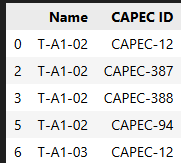

In [111]:
from google import genai
# from dotenv import load_dotenv
# load_dotenv()

In [112]:
client = genai.Client()

In [113]:
generation_config = {
    "temperature": 0.0,  # Controls randomness. Lower is more deterministic.
    "seed": 2024         # Ensures reproducible results for the same prompt.
}

In [116]:
responses = []

for idx, row in df.iterrows():
    threat = row['summary_th_df']
    prompt = create_prompt(threat)

    try:
        response = client.models.generate_content(model = "gemini-2.5", contents=prompt,generation_config=generation_config)
        print("Here")
        responses.append(response.text)
    except Exception as e:
        responses.append(f"[ERROR] {e}")


In [115]:
display(Markdown(response.text))

Based on the threat summary: "A Threat with the title Malicious function or application monitors messaging across A1 interface and the description Internal threat actor can gain access to the messaging across the A1 interface for a MiTM attack to read policy," here are the five most appropriate CAPEC IDs:

1.  **CAPEC-94: Man-in-the-Middle**
    *   **Reasoning:** The description explicitly states "for a MiTM attack." This CAPEC directly covers the core attack pattern where an attacker intercepts and relays communications between two parties, making them believe they are communicating directly.

2.  **CAPEC-109: Network Eavesdropping**
    *   **Reasoning:** The threat involves "monitors messaging across A1 interface" and gaining "access to the messaging...to read policy." Network Eavesdropping directly describes the passive interception of network traffic to gain information, which is a foundational aspect of "monitoring messaging" and can precede or accompany an active MiTM.

3.  **CAPEC-59: Traffic Redirection**
    *   **Reasoning:** A Man-in-the-Middle attack fundamentally relies on diverting network traffic through the attacker. Traffic Redirection is the specific mechanism by which the attacker causes network traffic intended for one destination to be sent to another location (under the attacker's control), enabling the MiTM.

4.  **CAPEC-113: Subverting the Device**
    *   **Reasoning:** The threat begins with "Malicious function or application." To monitor messaging or perform MiTM, the attacker often needs to establish a presence or introduce malicious software onto a network device, server, or endpoint that handles the A1 interface traffic. Subverting the Device describes how an attacker introduces malicious software to gain control or access information, which would be necessary to implement the "malicious function or application."

5.  **CAPEC-104: Packet Sniffing**
    *   **Reasoning:** "Monitors messaging across A1 interface" and "gain access to the messaging" points directly to the technical act of capturing data packets. Packet Sniffing is a specific technique used to capture and analyze network traffic, which is essential for "reading policy" in an intercepted communication stream. It's the underlying technical method for the "eavesdropping" aspect.

### RAG

### Fine Tuning with LoRA

## Evaluation